<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a SAM model code **

reference code source:[https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb](http://)

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install git+https://github.com/huggingface/transformers.git@v4.36.1
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install albumentations

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g8n7mw9c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g8n7mw9c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/huggingface/transformers.git (to revision v4.36.1) to /tmp/pip-req-build-0wmz38pg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-0wmz38pg
  Running command git checkout -q 4c920c49503c8c8500deaa7fa84c2d86b864f006
  Resolved https://github.com/huggingface/transformers.git to commit 4c920c49503c8c8500deaa7fa84c2d86b864f006
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filena

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from datasets import Dataset
from PIL import Image
import torch
from transformers import SamModel, SamConfig, SamProcessor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import albumentations as A
from torch.nn.functional import interpolate
from tqdm import tqdm
from statistics import mean
from torch.nn.functional import threshold, normalize

**Inference**

In [5]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/kaggle/input/final-model/mito_model_checkpoint_7_epoch_prompt_exceptclass0_increase_threshold0.5.pth"))

<All keys matched successfully>

In [6]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

Generate test data

In [7]:
import numpy as np

def get_bounding_box_image(ground_truth_map):
    # Assume ground_truth_map is a NumPy array representing the image

    # Convert to grayscale if the image is in color
    if len(ground_truth_map.shape) == 3:
        ground_truth_map = ground_truth_map.mean(axis=2)

    # Threshold the image to create a binary mask
    binary_mask = (ground_truth_map > 0).astype(np.uint8)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box from the first contour
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])

        # Add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape[:2]
        x_min = max(0, x - np.random.randint(0, 20))
        x_max = min(W, x + w + np.random.randint(0, 20))
        y_min = max(0, y - np.random.randint(0, 20))
        y_max = min(H, y + h + np.random.randint(0, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        # Return a default bounding box if no contours are found
        return [0, 0, 0, 0]

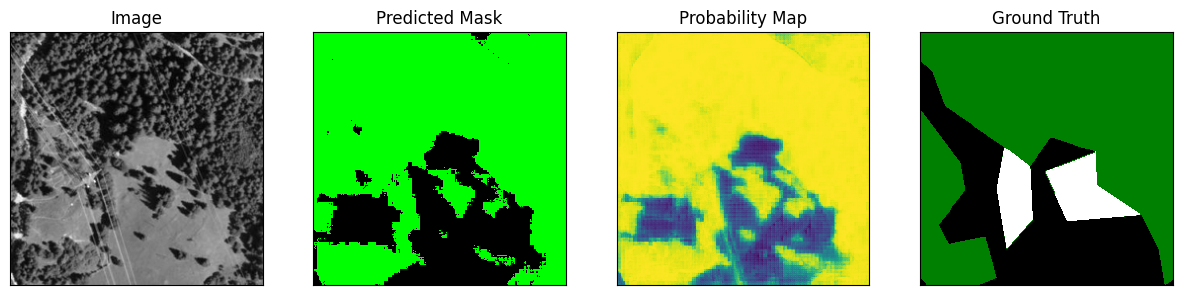

0
class  0  iou  0.5906834315408528
0
class  1  iou  0.8121779859484778


In [9]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import cv2

# let's take a random training example
idx = 0 # random.randint(0, filtered_test_images.shape[0]-1)
image_path = "/test-show/input_2780_2020.tif"
mask_path = "/test-show/target_2780_2020.tif"

# Specify the desired size for resizing
target_size = (256, 256)

# Initialize lists to store filtered images and masks
images = []
masks = []

# Iterate over RGB image files

rgb_image = Image.open(image_path)

# Check if the image has the desired size
if rgb_image.size == target_size:

    # Read corresponding mask label
    mask_label = tifffile.imread(mask_path)

    # Convert RGB image to grayscale and resize
    grayscale_image = rgb_image.convert("L").resize(target_size)
    mask_label[mask_label>1] = 2
    mask_label = mask_label.astype(np.uint8)
    mask_label = mask_label.squeeze()
    #print(mask_label)

    # Append resized images and masks to lists
    images.append(np.array(grayscale_image))
    masks.append(np.array(mask_label))

filtered_test_show_images = np.array(images) 
filtered_test_show_masks = np.array(masks) 

# Convert NumPy arrays to Pillow images and store in a dictionary
test_show_dict = {
    "image": [Image.fromarray(img) for img in filtered_test_show_images],
    "label": [Image.fromarray(mask) for mask in filtered_test_show_masks],
}
# load image
test_show_dataset = Dataset.from_dict(test_show_dict)

test_image = test_show_dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_show_dataset[idx]["label"])

prompt = get_bounding_box_image(np.array(test_image))
# prepare image + box prompt for the model

#inputs = processor(test_image, input_points = input_points, return_tensors="pt")
inputs = processor(test_image, input_boxes = [[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()
num_classes = 3
# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
green_rgb = (0/255, 255/255, 0/255)

cmap1 = plt.cm.colors.ListedColormap(['black', green_rgb])

axes[1].imshow(medsam_seg, cmap=cmap1)  # Assuming the second image is grayscale
axes[1].set_title("Predicted Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")
cmap2 = plt.cm.colors.ListedColormap(['black', 'green','white'])
axes[3].imshow(ground_truth_mask,cmap= cmap2)  # Assuming the second image is grayscale
axes[3].set_title("Ground Truth")
# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
class_ious = [[] for _ in range(num_classes-1)]
valid_indices = np.where(ground_truth_mask != 2)

for class_id in range(num_classes-1):
    # Only consider valid indices for both ground_truth_mask and medsam_seg
    valid_ground_truth_mask = ground_truth_mask[valid_indices]
    valid_medsam_seg = medsam_seg[valid_indices]

    intersection = np.logical_and(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)
    union = np.logical_or(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)

    if np.sum(union) > 0:
        class_iou = np.sum(intersection) / np.sum(union)
    else:
        class_iou = np.nan

    class_ious[class_id].append(class_iou)
    print(idx)
    print("class ", class_id, " iou ", class_iou)
